# 第13週：社群網路分析校正回歸事件

**Author:** 蘇舫萱  
**Date created:** 2021/12  
**Last modified:** 2021/12  

本週課程為「社群網路分析」，主要是上週基本圖學在社群上的分析與應用。  
我們會先透過LDA為資料進行主題分析，再以不同角度對社群進行篩選，進行網路分析。  

## 大綱

- 1. 套件說明
- 2. 資料前處理
    - 2.1 基本資料介紹
    - 2.2 資料清理
    - 2.3 文章斷詞與整理
- 3. LDA
    - 3.1 LDA資料準備
    - 3.2 建立LDA
    - 3.3 判斷每筆發文
    - 3.4 資料內容探索
- 4. 社群網路圖
    - 4.1 基本網路圖
    - 4.2 資料篩選
    - 4.3 以日期篩選社群
    - 4.4 以主題篩選社群
    - 4.5 使用者是否受到歡迎


## 1. 套件說明
下面列出在本次實作過程中我們所使用到的相關套件，在這個Jupyter Notebook當中我們將會簡單的展示這些套件的使用方式，關於各個套件的進階使用請同學參照其官網的說明。
- pandas: 一個資料分析的函式庫，提供了DataFrame等資料格式，與資料處理的函數。
- numpy: 為科學運算所提供的套件。提供許多數學公式的實作以及高效率的陣列、矩陣運算。
- NLTK: 全名為Natural Language Tool Kit，自然語言處理工具。
- jieba: 中文斷詞套件。
- re: 正規表達式套件。
- math: 數學運算工具。
- collections: 提供額外的數據類型。
- wordcloud: 文字雲繪圖工具。
- matplotlib: 繪圖工具。
- networkx: 網絡圖建構、繪製工具。
- CountVectorizer,TfidfTransformer: sklearn中計算詞頻與tf-idf的套件。
- numpy.linalg: 矩陣與向量運算套件。
- gensim: 主題模型函式庫
- pyLDAvis: 互動式LDA視覺化套件

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib
import re
import jieba
import jieba.analyse
from datetime import datetime
from wordcloud import WordCloud 
import math
from nltk import ngrams
from collections import defaultdict
from nltk import FreqDist
from collections import Counter, namedtuple
import networkx as nx
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from numpy.linalg import norm
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import pyLDAvis.gensim_models

In [2]:
# 移除警告語，視覺上比較乾淨
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

C:\Users\eva07\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [4]:
plt.rcParams['font.sans-serif']=['SimHei'] #使圖中中文能正常顯示
plt.rcParams['axes.unicode_minus']=False #使負號能夠顯示

## 2. 資料前處理

### 2.1 基本資料介紹
- 資料來源: 文字平台收集PTT Gossip版2020/05/21 ~ 2021/05/23  所有文章
- 資料集： ptt_articleMetaData.csv; ptt_articleReviews.csv
- 關鍵字：校正回歸、校正迴歸、疫情、確診
- 資料時間：2020/05/21 ~ 2021/05/23 
- 資料筆數：共 3225 篇文章

> 這次我們針對5/22發生的校正回歸事件，討論ptt版上相關討論的發文風向，主要針對以下方向分析：  
1.校正回歸的討論重點有哪些? 主要分為哪幾種風向?  
2.風向最偏哪邊?  
3.討論校正回歸的社群網路如何分布?  
4.校正回歸的意見領袖有誰?網友的推噓狀態如何?

In [5]:
#匯入資料
MetaData = pd.read_csv('./raw_data/ptt0523_articleMetaData.csv', encoding='UTF-8')
Reviews = pd.read_csv('./raw_data/ptt0523_articleReviews.csv', encoding='UTF-8')

In [6]:
MetaData.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence
0,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,乳題啦\n小弟我已經很久沒有出遊了\n上禮拜五疫情炸開\n頓時社群軟體一堆人發了文章\n看好...
1,[問卦]當初讓華航倒閉不就好了???,2021/05/20,16:01:53,https://www.ptt.cc/bbs/Gossiping/M.1621526515....,eddisontw,Gossiping,15,8,1,搞什麼3+11\n說隔離14天華航就要倒了\n那華航倒了又怎樣\n很了不起嗎\n本土疫情死一...
2,[新聞]簡訊實聯制快速好用陳其邁也是幕後「推,2021/05/20,16:02:43,https://www.ptt.cc/bbs/Gossiping/M.1621526566....,fcfd,Gossiping,98,16,25,影／簡訊實聯制快速好用 陳其邁也是幕後「推手」！\n2021-05-20 12:59 聯合報...


In [7]:
Reviews.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,cmtPoster,cmtStatus,cmtDate,cmtContent
0,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,ppptttqaz,→,2021-05-21 00:00:00,:可以扣掉范雲嗎
1,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,nobeldd,推,2021-05-21 00:00:00,:督
2,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,okichan,推,2021-05-21 00:01:00,:假掰


In [8]:
# 合併每篇文章對應的留言
Reviews = MetaData.iloc[:,0:-1].merge(Reviews.loc[:,["artUrl", "cmtContent", "cmtPoster", "cmtStatus", "cmtContent"]], how = "left", on = 'artUrl')

In [9]:
print(Reviews.shape)
Reviews.head(3)

(158548, 13)


,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,:可以扣掉范雲嗎,ppptttqaz,→,:可以扣掉范雲嗎
1,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,:督,nobeldd,推,:督
2,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,:假掰,okichan,推,:假掰


### 2.2 資料清理  
- 去除特殊字元與標點符號

In [10]:
#移除PTT貼新聞時會出現的格式用字
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(媒體來源|記者署名|完整新聞標題|完整新聞內文|完整新聞連結|(或短網址)|備註:|備註請放最後面|違者新聞文章刪除)', '', str(x)))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('(http|https)://.*', '', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('\n', ',', x))
MetaData['sentence'] = MetaData.sentence.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

In [11]:
#整理Reviews格式
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub(':', '', str(x)))
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('\n', ',', x))
# Reviews['cmtContent'] = Reviews.cmtContent.apply(lambda x: re.sub('[a-zA-Z0-9]+', ',', x))

### 2.3 文章斷詞與整理

In [12]:
#設定繁體中文詞庫
jieba.set_dictionary('./dict/dict.txt.big')

#新增疫情相關自定義字典
jieba.load_userdict('./dict/mask_lexicon.txt')

#新增stop words
#jieba.analyse.set_stop_words('./dict/stop_words.txt') #jieba.analyse.extract_tags才會作用
with open('./dict/stopwords.txt',encoding="utf-8") as f:
    stopWords = [line.strip() for line in f.readlines()]

Building prefix dict from D:\My Documents\桌面\school\助教\week13\dict\dict.txt.big ...
Dumping model to file cache C:\Users\eva07\AppData\Local\Temp\jieba.u4f22bf12ad7e5b52373ce84622602086.cache
Loading model cost 1.759 seconds.
Prefix dict has been built successfully.


In [13]:
# 設定斷詞 function
def getToken(row):
    seg_list = jieba.lcut(row)
    seg_list = [w for w in seg_list if w not in stopWords and len(w)>1] # 篩選不在停用字的字與字元數大於1的字詞
    return seg_list

In [14]:
data = MetaData.copy()
data['word'] = data.sentence.apply(getToken)

In [15]:
data.head(3)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word
0,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,"乳題啦,小弟我已經很久沒有出遊了,上禮拜五疫情炸開,頓時社群軟體一堆人發了文章,看好了世界系...","[乳題, 小弟, 很久沒, 出遊, 禮拜五, 疫情, 炸開, 社群, 軟體, 一堆, 人發,..."
1,[問卦]當初讓華航倒閉不就好了???,2021/05/20,16:01:53,https://www.ptt.cc/bbs/Gossiping/M.1621526515....,eddisontw,Gossiping,15,8,1,"搞什麼,+,,說隔離,天華航就要倒了,那華航倒了又怎樣,很了不起嗎,本土疫情死一堆人,跟華航...","[隔離, 華航, 華航, 了不起, 本土, 疫情, 一堆, 華航, 倒閉, 疫情, 肆虐, ..."
2,[新聞]簡訊實聯制快速好用陳其邁也是幕後「推,2021/05/20,16:02:43,https://www.ptt.cc/bbs/Gossiping/M.1621526566....,fcfd,Gossiping,98,16,25,"影／簡訊實聯制快速好用 陳其邁也是幕後「推手」！,,-,-, ,:, 聯合報 / 記者王昭月...","[簡訊, 實聯制, 快速, 好用, 陳其邁, 幕後, 推手, 聯合報, 王昭月, 高雄, 即..."


## 3. LDA

### 3.1 LDA資料準備
- 將斷詞結果轉成list型式，使用id2word 將斷詞結果生成字典

In [16]:
token_data = data['word'].tolist()

In [17]:
id2word = corpora.Dictionary(token_data)
print('資料集字典：')
print(id2word)

資料集字典：
Dictionary(26983 unique tokens: ['一堆', '世界', '乳題', '亂跑', '人才']...)


- 將斷詞結果建構語料庫(corpus)，利用語料庫把每篇文章數字化。  
- 每篇文章、每個詞彙都被賦予一個 ID 及頻率(word_id，word_frequency)。

In [18]:
corpus = [id2word.doc2bow(text) for text in token_data]
print('第一篇文章 corpus :')
print(corpus[0][:10])

第一篇文章 corpus :
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]


### 3.2 建立LDA

In [19]:
ldamodel = gensim.models.ldamulticore.LdaMulticore(
    corpus=corpus,  # 文檔語料庫
    id2word=id2word, # 詞彙字典
    num_topics=3, # 生成幾個主題數
    random_state=1205, # 亂數
    iterations = 1000, # 每個文章訓練的次數，可以設定高一點讓模型收斂
    passes=5, # 模型訓練次數
)

### 3.3 判斷每筆發文的主題
**查看 LDA 各主題代表字**  
- 查看每個主題的單詞分佈

In [20]:
# 每個主題重要的前25個關鍵字
topics = ldamodel.print_topics(num_words=25)
for topic in topics:
    print(topic)
    print("")

(0, '0.011*"校正回歸" + 0.011*"確診" + 0.009*"疫情" + 0.006*"數字" + 0.005*"真的" + 0.004*"檢驗" + 0.004*"台灣" + 0.003*"有沒有" + 0.003*"防疫" + 0.003*"政府" + 0.003*"雙北" + 0.003*"塞車" + 0.003*"中央" + 0.003*"幾天" + 0.003*"醫院" + 0.003*"感染" + 0.003*"地方" + 0.003*"萬華" + 0.003*"公布" + 0.003*"記者會" + 0.002*"在家" + 0.002*"資料" + 0.002*"指揮中心" + 0.002*"爆發" + 0.002*"員工"')

(1, '0.016*"疫苗" + 0.016*"疫情" + 0.016*"台灣" + 0.007*"防疫" + 0.007*"政府" + 0.006*"口罩" + 0.006*"確診" + 0.004*"中國" + 0.004*"病毒" + 0.003*"美國" + 0.003*"真的" + 0.003*"爆發" + 0.003*"校正回歸" + 0.003*"民眾" + 0.002*"萬華" + 0.002*"去年" + 0.002*"有沒有" + 0.002*"認知" + 0.002*"國家" + 0.002*"感染" + 0.002*"陳時中" + 0.002*"指揮中心" + 0.002*"市長" + 0.002*"地方" + 0.002*"作戰"')

(2, '0.017*"確診" + 0.014*"校正回歸" + 0.013*"疫情" + 0.007*"防疫" + 0.006*"台灣" + 0.004*"政府" + 0.003*"中央" + 0.003*"地方" + 0.003*"人數" + 0.003*"真的" + 0.003*"公布" + 0.003*"本土" + 0.003*"有沒有" + 0.003*"醫院" + 0.003*"數字" + 0.003*"校正" + 0.003*"八卦" + 0.003*"個案" + 0.003*"回歸" + 0.002*"時間" + 0.002*"案例" + 0.002*"新增" + 0.002*"口罩" + 0.002*"幾天" + 0.002*

**可以歸納出**
- topic 0 = “校正回歸相關報導”
- topic 1 = “疫苗相關看法與報導”
- topic 2 = “校正回歸質疑相關”  

<b><mark><font color=red>*以下我們挑出 第零個主題 與 第二個主題 來做比較。 </font></mark></b>   

**以每筆發文的"主題分佈"中分數最大的主題當作該文章的主題**

In [64]:
# 取得每筆發文的主題分佈
topics_doc = ldamodel.get_document_topics(corpus,minimum_probability=0)

# 把每筆發文的主題分佈存成list
probabilities = [ [entry[1] for entry in doc] for doc in topics_doc ]
print(probabilities[0:3])

# 找出probabilities最大的主題 存入 doc_list
doc_list = [np.argmax(t) for t in probabilities]

[[0.011701166, 0.011787614, 0.9765112], [0.7567506, 0.014470427, 0.22877899], [0.9953116, 0.0023270277, 0.0023613342]]


In [65]:
# 將結果放進 DataFrame裏
data['topic'] = doc_list

In [66]:
data[["artTitle","topic"]].head(5)

,artTitle,topic
0,[問卦]喊「我們一起度過」是什麼心態？,2
1,[問卦]當初讓華航倒閉不就好了???,0
2,[新聞]簡訊實聯制快速好用陳其邁也是幕後「推,0
3,Re:[新聞]新北疫情｜中和「方唐鏡」拒戴罩 竟在超,0
4,Re:[問卦]你覺得疫情真的跟中共認知作戰有關嗎,1


### 3.4 資料內容探索

**查看兩個主題的內容**

In [67]:
data[(data["topic"]==0)&(data["artTitle"].str.contains("校正"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
1492,[問卦]以前從來沒聽過校正回歸要繳回畢業,0
1759,[問卦]我都唸校正回歸,0
2110,[問卦]保險話術講校正回歸484感覺很專業？,0
1899,[問卦]校正回歸會成為2021最夯用語嗎,0
2859,Re:[爆卦]核三一號機校正回歸99.117%滿載發電啦！,0


In [68]:
data[(data["topic"]==2)&(data["artTitle"].str.contains("校正"))][["artTitle","topic"]].sample(n=5)

,artTitle,topic
2779,Re:[爆卦]校正回歸背後的真象,2
2623,[問卦]+721和校正回歸的輿論風向,2
2234,Re:[問卦]我來說明為何要校正回歸這是正確的方,2
2237,Re:[問卦]校正回歸該怎麼算？,2
1499,Re:[問卦]400例校正回歸是什麼,2


這次我們把討論焦點放在校正回歸上，從主題分布大概可以看到兩類觀點：

- 主題零： 從上面的文章標題可以看出，是在詢問或解釋校正回歸的意思

- 主題二： 從上面的文章標題可以看出，大部分是網友在調侃校正回歸

**畫出每日主題分布**

In [69]:
# 轉換artDate為 Python 日期格式
data['artDate'] = pd.to_datetime(data['artDate'], format="%Y-%m-%d")

In [70]:
# groupby 日期、主題並計算文章篇數
date_topic = pd.DataFrame({
    'count':data.groupby(['artDate','topic']).size()
})

date_topic = date_topic.reset_index()
date_topic

,artDate,topic,count
0,2021-05-20,0,26
1,2021-05-20,1,53
2,2021-05-20,2,45
3,2021-05-21,0,176
4,2021-05-21,1,369
5,2021-05-21,2,375
6,2021-05-22,0,632
7,2021-05-22,1,491
8,2021-05-22,2,1058


In [71]:
date_df = date_topic.pivot_table(index='artDate', values='count', columns='topic').fillna(0).reset_index()
date_df.columns = ['artDate', 'topic0', 'topic1', 'topic2']
date_df = date_df.set_index('artDate')
date_df

,topic0,topic1,topic2
artDate,,,
2021-05-20,26,53,45
2021-05-21,176,369,375
2021-05-22,632,491,1058


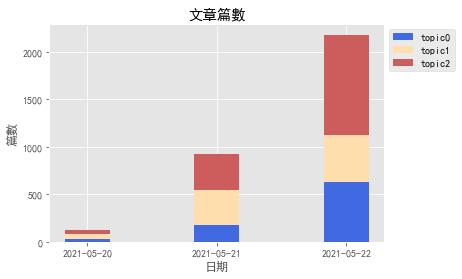

In [72]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

ind = np.arange(3)    
width = 0.35       

plt.bar(ind, date_df["topic0"], width, label="topic0",color='royalblue')
plt.bar(ind, date_df["topic1"], width,  bottom=date_df["topic0"], label="topic1",color='navajowhite')
plt.bar(ind, date_df["topic2"], width,  bottom=date_df["topic0"]+date_df["topic1"], label="topic2",color='indianred')


plt.xticks(ind, ('2021-05-20', '2021-05-21', '2021-05-22'))
plt.title('文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數') # y軸標題
# plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置

plt.show()

In [73]:
ratio_df = date_df.copy()
ratio_df['sum'] = ratio_df.topic0 + ratio_df.topic1 + ratio_df.topic2

for i in range(0,3):
    ratio_df['topic'+str(i)] = ratio_df['topic'+str(i)] / ratio_df['sum']

ratio_df

,topic0,topic1,topic2,sum
artDate,,,,
2021-05-20,0.209677,0.427419,0.362903,124
2021-05-21,0.191304,0.401087,0.407609,920
2021-05-22,0.289775,0.225126,0.485099,2181


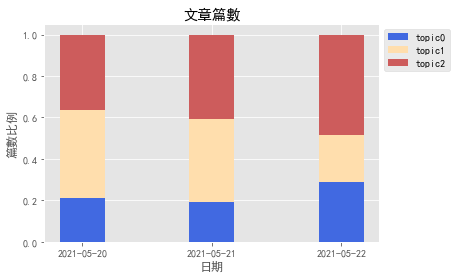

In [74]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式

ind = np.arange(3)    
width = 0.35       

plt.bar(ind, ratio_df["topic0"], width, label="topic0",color='royalblue')
plt.bar(ind, ratio_df["topic1"], width,  bottom=ratio_df["topic0"], label="topic1",color='navajowhite')
plt.bar(ind, ratio_df["topic2"], width,  bottom=ratio_df["topic0"]+ratio_df["topic1"], label="topic2",color='indianred')


plt.xticks(ind, ('2021-05-20', '2021-05-21', '2021-05-22'))
plt.title('文章篇數') # 標題
plt.xlabel('日期') # x軸標題
plt.ylabel('篇數比例') # y軸標題
# plt.xticks(rotation=30)
plt.legend(bbox_to_anchor=(1,1), loc='upper left') #標示的位置

plt.show()

## 4. 社群網路圖
社群網絡分析就是運用圖論(Graph theory)從這些節點和連結去研究人與人之間的關係以及整個群體的結構。

### 4.1 基本網路圖

In [80]:
data.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic
0,[問卦]喊「我們一起度過」是什麼心態？,2021-05-20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,"乳題啦,小弟我已經很久沒有出遊了,上禮拜五疫情炸開,頓時社群軟體一堆人發了文章,看好了世界系...","[乳題, 小弟, 很久沒, 出遊, 禮拜五, 疫情, 炸開, 社群, 軟體, 一堆, 人發,...",2


In [81]:
Reviews.head(1)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,cmtContent,cmtPoster,cmtStatus,cmtContent
0,[問卦]喊「我們一起度過」是什麼心態？,2021/05/20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,:可以扣掉范雲嗎,ppptttqaz,→,:可以扣掉范雲嗎


In [82]:
# 把reviews中 cmtPoster(回覆者), cmtStatus(推噓), cmtContent(留言) 合併到 data的資料表
posts_Reviews = Reviews.loc[:,["artUrl", "cmtPoster", "cmtStatus", "cmtContent"]]
posts_Reviews  = pd.merge(data, posts_Reviews, how="right", on="artUrl")
posts_Reviews = posts_Reviews[posts_Reviews["commentNum"]>0]

In [83]:
posts_Reviews.head(2)

,artTitle,artDate,artTime,artUrl,artPoster,artCat,commentNum,push,boo,sentence,word,topic,cmtPoster,cmtStatus,cmtContent,cmtContent
0,[問卦]喊「我們一起度過」是什麼心態？,2021-05-20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,"乳題啦,小弟我已經很久沒有出遊了,上禮拜五疫情炸開,頓時社群軟體一堆人發了文章,看好了世界系...","[乳題, 小弟, 很久沒, 出遊, 禮拜五, 疫情, 炸開, 社群, 軟體, 一堆, 人發,...",2,ppptttqaz,→,:可以扣掉范雲嗎,:可以扣掉范雲嗎
1,[問卦]喊「我們一起度過」是什麼心態？,2021-05-20,16:00:24,https://www.ptt.cc/bbs/Gossiping/M.1621526426....,BuzzerBeater,Gossiping,3,2,0,"乳題啦,小弟我已經很久沒有出遊了,上禮拜五疫情炸開,頓時社群軟體一堆人發了文章,看好了世界系...","[乳題, 小弟, 很久沒, 出遊, 禮拜五, 疫情, 炸開, 社群, 軟體, 一堆, 人發,...",2,nobeldd,推,:督,:督


In [84]:
# 取出 cmtPoster(回覆者)、artPoster(發文者)、artUrl(文章連結) 三個欄位
link = posts_Reviews.loc[:,["cmtPoster", "artPoster", "artUrl"]]
link.head(5)

,cmtPoster,artPoster,artUrl
0,ppptttqaz,BuzzerBeater,https://www.ptt.cc/bbs/Gossiping/M.1621526426....
1,nobeldd,BuzzerBeater,https://www.ptt.cc/bbs/Gossiping/M.1621526426....
2,okichan,BuzzerBeater,https://www.ptt.cc/bbs/Gossiping/M.1621526426....
3,yoyo365,eddisontw,https://www.ptt.cc/bbs/Gossiping/M.1621526515....
4,monitor,eddisontw,https://www.ptt.cc/bbs/Gossiping/M.1621526515....


In [87]:
len(link)

158478

使用 cmtPoster(回覆者)、artPoster(發文者) 建立兩者的連結，這裡先嘗試使用前100筆資料(總共有158478筆資料)

In [85]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,100):
    G.add_edge(link["cmtPoster"][i], link["artPoster"][i])
    

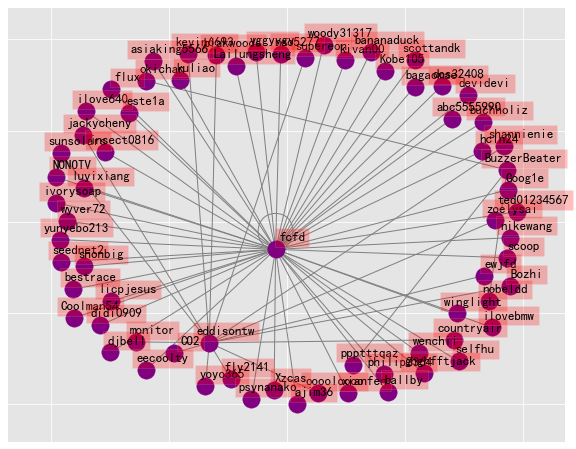

In [86]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 font_size=16,
#                  width=weights,
                 edge_color='grey',
                 node_color='purple',
                 with_labels = False,
                 ax=ax)

# 增加 labels
for key, value in pos.items():
    x, y = value[0]+.07, value[1]+.045 #調整label的位置(右上)
    ax.text(x, y,
            s=key,
            bbox=dict(facecolor='red', alpha=0.25),
            horizontalalignment='center', fontsize=13)
    
plt.show()

資料太多太雜(158478筆資料)，所以我們下面需要做進一步篩選。

### 4.2 資料篩選

資料篩選的方式：

- 文章:文章日期、留言數(commentNum)
- link、node:degree

看一下文章留言數大概都多少(方便後面篩選)

Text(0, 0.5, 'count')

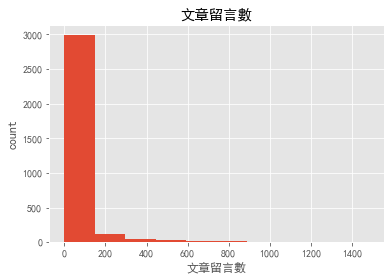

In [255]:
plt.figure(figsize=(6,4))   # 顯示圖框架大小 (寬,高)
plt.style.use("ggplot")     # 使用ggplot主題樣式
plt.rcParams['font.sans-serif']=['SimHei'] #使中文能正常顯示
plt.hist(data["commentNum"])

plt.title('文章留言數')
plt.xlabel('文章留言數')
plt.ylabel('count')

依據發文數或回覆數篩選post和review

In [256]:
# 帳號發文篇數
pd.DataFrame(data.groupby("artPoster").size(),columns = ['count']).reset_index().sort_values(by="count",ascending=False)

,artPoster,count
2268,xampp,7
1,A6,6
145,Fantasy7th,6
1233,ilw4e,6
1245,ioupoiu,6
...,...,...
889,curtpy,1
888,currykukuo,1
886,currry,1
885,cuba391156,1


In [257]:
# 檢視人數
print("發文者數量總共:",len(set(posts_Reviews["artPoster"])))
print("回覆者數量總共:",len(set(posts_Reviews["cmtPoster"])))

發文者數量總共: 2315
回覆者數量總共: 26496


**標記所有出現過的使用者**
- poster：只發過文、發過文+留過言
- replyer：只留過言

In [258]:
# 用set()得到不重複的集合
s = set(list(posts_Reviews["artPoster"])+list(posts_Reviews["cmtPoster"]))

In [259]:
allPoster = pd.DataFrame(list(s),columns=["user"])

In [260]:
allPoster["type"] = allPoster["user"].apply(lambda x: "poster" if x in list(data["artPoster"]) else "replayer")

In [261]:
allPoster.head(5)

,user,type
0,theyolf,replayer
1,airflow,replayer
2,tairshin,replayer
3,app325,poster
4,aaaaa66666,poster


### 4.3 以日期篩選社群

事件是5/22爆發的，我們挑出當天的文章和回覆

In [262]:
# 篩選日期為2021-05-22 且 留言數>200的
posts_Reviews_0522 = (posts_Reviews.query('artDate == "2021-05-22"')
                      .query('commentNum>200')
                      .groupby(['cmtPoster','artUrl'],as_index=False).size()
                     )

In [263]:
# 篩選有人在同一篇文章重複回覆大於5次
posts_Reviews_0522 = posts_Reviews_0522.query('size>5')
posts_Reviews_0522.head(3)

,cmtPoster,artUrl,size
123,ARTORIA,https://www.ptt.cc/bbs/Gossiping/M.1621675236....,7
346,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663419....,8
347,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663653....,9


In [264]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522 = pd.merge(posts_Reviews_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522.reset_index(inplace=True, drop=True) #重設index
link_0522.head(3)

,cmtPoster,artUrl,size,artPoster
0,ARTORIA,https://www.ptt.cc/bbs/Gossiping/M.1621675236....,7,FishJocker
1,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663419....,8,DsLove710
2,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663653....,9,hstf


In [265]:
# Create network plot 
# nx.Graph()為無向圖 ; nx.DiGraph()為有向圖
G = nx.Graph()

# 建立 nodes 間的連結
for i in range(0,len(link_0522)):
    G.add_edge(link_0522["cmtPoster"][i], link_0522["artPoster"][i])

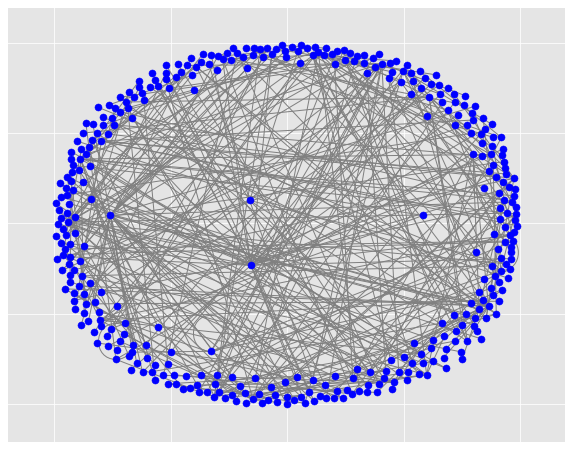

In [266]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color="blue",
                 with_labels = False,
                 ax=ax)
    
plt.show()

**加上nodes的顯示資訊**  
用使用者的身份來區分點的顏色
- poster:red(有發文)
- replyer:blue(只有回覆文章)

In [267]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

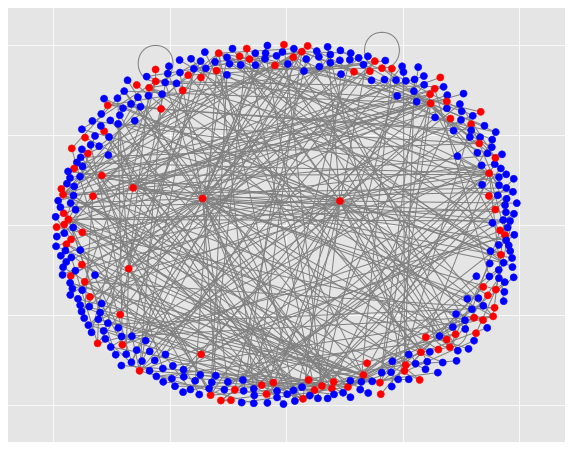

In [268]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=2)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)
    
plt.show()

為點加上帳號名字，用degree篩選要顯示出的使用者(degree>5)，以免圖形被密密麻麻的文字覆蓋。  

In [269]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [270]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [271]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees

['shoes922', 'cleanID', 'xingting', 'Janice1998']

In [272]:
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

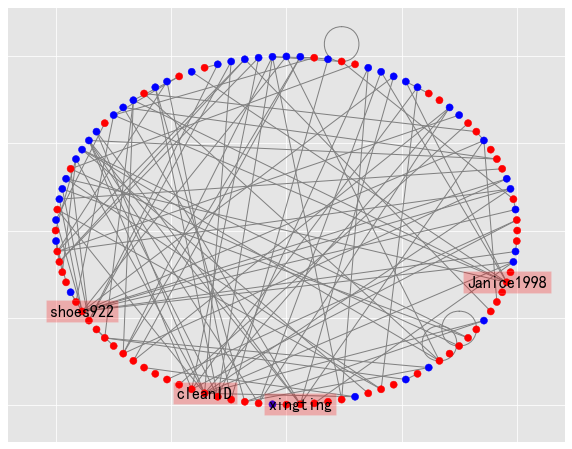

In [273]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
# pos = nx.spring_layout(G, k=2)
pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color='grey',
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

**計算Centrality**  
找出重要的點  
[NetworkX Centrality](https://networkx.org/documentation/stable/reference/algorithms/centrality.html)  

- degree centrality: people with many connections tend to be important
- eigenvector centrality: people who are connected to more important people tend to be important
- pagerank centrality: remedy Eigenvector measure by normalization
- betweenness centrality: People who connect to more communities tend to be more important

In [288]:
# degree centrality
degree = nx.degree_centrality(G)
degree

{'FishJocker': 0.009708737864077669,
 'Annis812': 0.038834951456310676,
 'DsLove710': 0.04854368932038834,
 'hstf': 0.029126213592233007,
 'oaoa0123': 0.019417475728155338,
 'liebearashi': 0.009708737864077669,
 'Anvec': 0.019417475728155338,
 'ich2': 0.019417475728155338,
 'shoes922': 0.10679611650485436,
 'golang': 0.038834951456310676,
 'Behind4': 0.019417475728155338,
 'stock5566': 0.038834951456310676,
 'GETpoint': 0.009708737864077669,
 'lastmile': 0.038834951456310676,
 'minlove34': 0.019417475728155338,
 'ac9607': 0.009708737864077669,
 'Makubex82': 0.0,
 'shadowmelo': 0.009708737864077669,
 'seysem': 0.009708737864077669,
 'lukcat': 0.038834951456310676,
 'cleanID': 0.08737864077669902,
 'solarsea': 0.038834951456310676,
 'bisacodyl': 0.019417475728155338,
 'WuSam': 0.029126213592233007,
 'violetphoeni': 0.029126213592233007,
 'Hunterrr': 0.019417475728155338,
 'royroy666': 0.009708737864077669,
 'xingting': 0.058252427184466014,
 'IDfor2010': 0.019417475728155338,
 'BOB1105':

In [296]:
# eigenvector centrality
eigenvector = nx.eigenvector_centrality(G)

In [290]:
# pagerank centrality
pr = nx.pagerank(G, alpha=0.9)

In [292]:
# betweenness centrality
between = nx.betweenness_centrality(G)

In [294]:
# 找出degree centrality最高的前5名
print("degree centrality:",sorted(degree, key=degree.get, reverse=True)[:5])

# 找出eigenvector centrality最高的前5名
print("eigenvector centrality:",sorted(eigenvector, key=eigenvector.get, reverse=True)[:5])

# 找出pagerank centrality最高的前5名
print("pagerank centrality:",sorted(pr, key=pr.get, reverse=True)[:5])

# 找出betweenness centrality最高的前5名
print("betweenness centrality:",sorted(between, key=between.get, reverse=True)[:5])

degree centrality: ['shoes922', 'cleanID', 'xingting', 'Janice1998', 'DsLove710']
eigenvector centrality: ['shoes922', 'cleanID', 'carsly', 'amida959', 'dostey']
pagerank centrality: ['shoes922', 'cleanID', 'Janice1998', 'xingting', 'DsLove710']
betweenness centrality: ['shoes922', 'cleanID', 'carsly', 'trywish', 'mygogocow']


我們可以看到基本的使用者關係，但是我們希望能夠將更進階的資訊視覺化。  
例如：使用者經常參與的文章種類，或是使用者在該社群網路中是否受到歡迎。

### 4.4 以主題篩選社群

挑選出2021-05-22當天的文章， 篩選一篇文章回覆5次以上者，且文章留言數大於200則， 文章主題歸類為0(報導相關)與2(調侃)者， 欄位只取：cmtPoster(評論者), artPoster(發文者), artUrl(文章連結), topic(主題)

In [233]:
# 加上topic
topic_0522 = pd.merge(link_0522,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic"]].drop_duplicates()

In [234]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522_topic = pd.merge(topic_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522_topic.reset_index(inplace=True, drop=True) #重設index
link_0522_topic.head(3)

,cmtPoster,artUrl,topic,artPoster
0,ARTORIA,https://www.ptt.cc/bbs/Gossiping/M.1621675236....,2,FishJocker
1,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663419....,2,DsLove710
2,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663653....,0,hstf


In [235]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge = []
for i in range(0,len(link_0522_topic)):
    G.add_edge(link_0522_topic["cmtPoster"][i], link_0522_topic["artPoster"][i])
    if link_0522_topic["topic"][i] == 0: #以主題區分顏色
        color_map_edge.append('orange') # 主題零:報導相關
    else: 
        color_map_edge.append('grey') # 主題二:調侃相關   

In [236]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [237]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [238]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]
degrees
# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

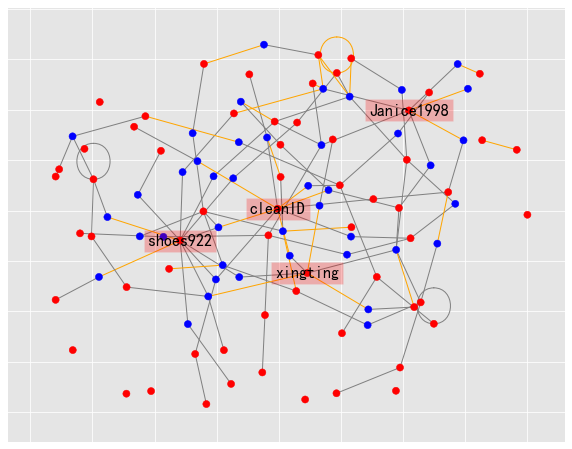

In [201]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G,k=0.3)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

報導主題相關為橘色，調侃相關為灰色。可以看出cleanID較多為報導相關留言，shoses922較多是調侃文章留言

### 4.5 使用者是否受到歡迎

PTT的回覆有三種，推文、噓文、箭頭，我們只要看推噓就好，因此把箭頭清掉。

In [321]:
# 加上status
status_0522 = pd.merge(link_0522,posts_Reviews,on=["cmtPoster","artUrl"],how="left")[["cmtPoster","artUrl","topic","cmtStatus"]].drop_duplicates()
# 去掉"→"的資料
status_0522 = status_0522[status_0522["cmtStatus"]!="→"]

In [322]:
# 因為需要artPoster所以merge link，之後使用drop_duplicates去除重複資料
link_0522_status = pd.merge(status_0522,link,on=["cmtPoster","artUrl"],how="left").drop_duplicates()
link_0522_status.reset_index(inplace=True, drop=True) #重設index
link_0522_status.head(3)

,cmtPoster,artUrl,topic,cmtStatus,artPoster
0,ARTORIA,https://www.ptt.cc/bbs/Gossiping/M.1621675236....,2,推,FishJocker
1,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663419....,2,推,DsLove710
2,Annis812,https://www.ptt.cc/bbs/Gossiping/M.1621663653....,0,推,hstf


In [323]:
# Create network plot 
G = nx.Graph()

# 建立 nodes 間的連結，及edge的顏色
color_map_edge_S = []
for i in range(0,len(link_0522_status)):
    G.add_edge(link_0522_status["cmtPoster"][i], link_0522_status["artPoster"][i])
    if link_0522_status["cmtStatus"][i] == "推":
        color_map_edge_S.append('orange')
    else: 
        color_map_edge_S.append('grey')    

In [324]:
# 刪除degree<1的點
to_be_removed = [x for  x in G.nodes() if G.degree(x) <= 1]
for x in to_be_removed:
    G.remove_node(x)

In [325]:
# 設定node顏色，red(有發文), blue(只有回覆)
color_map = []
for node in G.nodes():
    if allPoster[allPoster["user"]==node]["type"].item()=="replayer":
        color_map.append('blue')
    else: 
        color_map.append('red') 

In [326]:
# 找出degree>5的點
degrees = [node for (node, val) in G.degree() if val>5]

# 把找出的人加進label中
labels = {}  
for node in G.nodes():
    if node in degrees:
        #set the node name as the key and the label as its value 
        labels[node] = node

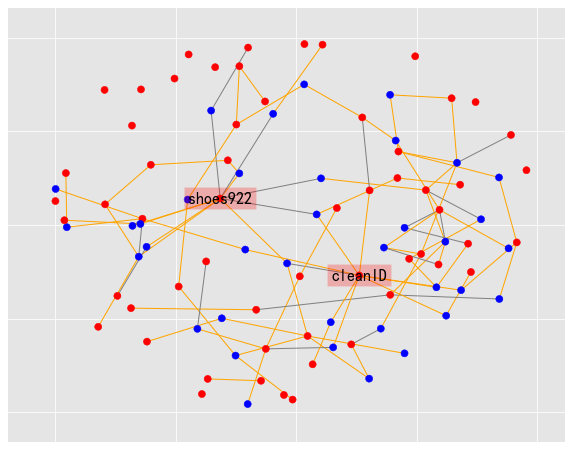

In [330]:
fig, ax = plt.subplots(figsize=(10, 8))

# 建立節點的布局 (節點位置)
pos = nx.spring_layout(G, k=0.4)
# pos = nx.shell_layout(G)

# networks
nx.draw_networkx(G, pos,
                 node_size=50,
                 edge_color=color_map_edge_S,
                 node_color=color_map,
                 with_labels = False,
                 ax=ax)

# 增加 labels
nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='black',
                        bbox=dict(facecolor='red', alpha=0.25),
                        horizontalalignment='center')
    
plt.show()

可以發現本次的討論中幾乎都是推文、噓文較少